In [1]:
from common import NWSL, Data, Colors, Fonts, Images, add_signature
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.interpolate import interp1d

In [12]:
season = "2025"

In [13]:
df = Data.get_nwsl_matches(season)
df = df[~df["is_playoffs"]]
matches_per_team = int(len(df.index) / len(df["home"].unique()) * 2)
df

,date,time,season,home,away,home_score,away_score,home_penalty_score,away_penalty_score,home_xg,away_xg,referee,attendance,stadium,is_forfeit,is_extra_time,is_pks,is_playoffs
1283,2024-03-16,12:00,2024,KCC,POR,5,4,0.0,0.0,2.3,1.4,Alex Billeter,11500.0,CPKC Stadium,False,False,False,False
1284,2024-03-16,16:00,2024,LOU,ORL,2,2,0.0,0.0,0.9,1.1,NaN,6123.0,Lynn Family Stadium,False,False,False,False
1285,2024-03-16,17:30,2024,UTA,CHI,0,2,0.0,0.0,2.2,1.2,NaN,20370.0,America First Field,False,False,False,False
1286,2024-03-16,19:00,2024,NC,HOU,5,1,0.0,0.0,3.2,0.2,NaN,5878.0,Sahlen's Stadium at WakeMed Soccer Park,False,False,False,False
1287,2024-03-17,15:00,2024,RGN,WAS,1,0,0.0,0.0,1.6,0.0,NaN,8557.0,Lumen Field,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,2024-11-02,17:00,2024,ORL,RGN,3,2,0.0,0.0,2.9,1.4,Melinda Sopka,7765.0,Inter&Co Stadium,False,False,False,False
1461,2024-11-02,19:30,2024,NC,WAS,0,1,0.0,0.0,0.4,0.7,Elvis Osmanovic,10026.0,Sahlen's Stadium at WakeMed Soccer Park,False,False,False,False
1462,2024-11-02,20:30,2024,HOU,BAY,2,3,0.0,0.0,1.1,2.1,Matthew Thompson,8176.0,Shell Energy Stadium,False,False,False,False
1463,2024-11-03,14:00,2024,CHI,KCC,1,3,0.0,0.0,1.3,1.9,Jaclyn Metz,5595.0,SeatGeek Stadium,False,False,False,False


In [14]:
team_points = {}

for team in df["home"].unique():
    points = []
    for i, game in df[(df["home"] == team) | (df["away"] == team)].iterrows():
        score = [game["home_score"], game["away_score"]]
        if game["away"] == team:
            score = score[::-1]

        points.append(1 if score[0] == score[1] else (3 if score[0] > score[1] else 0))
    team_points[team] = pd.Series(points)

In [15]:
window_size = 5

df2 = pd.DataFrame(columns=range(0, matches_per_team - window_size + 1))

for team, series in team_points.items():
    windows = series.rolling(window_size)
    moving_sum = windows.sum()
    moving_sum_list = moving_sum.tolist()

    # Remove null entries from the list
    final_list = moving_sum_list[window_size - 1 :]
    df2.loc[team] = pd.Series(final_list)
df2

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
KCC,13.0,13.0,11.0,9.0,11.0,9.0,9.0,11.0,11.0,11.0,...,7.0,6.0,6.0,4.0,7.0,8.0,11.0,11.0,13.0,13.0
LOU,7.0,7.0,6.0,5.0,5.0,5.0,7.0,7.0,7.0,7.0,...,4.0,4.0,3.0,6.0,9.0,6.0,6.0,6.0,6.0,3.0
UTA,3.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,...,8.0,8.0,8.0,7.0,6.0,6.0,6.0,9.0,10.0,10.0
NC,9.0,9.0,9.0,6.0,3.0,6.0,3.0,3.0,4.0,7.0,...,10.0,12.0,12.0,10.0,7.0,10.0,10.0,8.0,7.0,7.0
RGN,3.0,0.0,3.0,4.0,4.0,4.0,4.0,1.0,1.0,2.0,...,7.0,9.0,11.0,10.0,9.0,6.0,3.0,0.0,3.0,3.0
LA,7.0,7.0,9.0,9.0,6.0,4.0,4.0,2.0,5.0,5.0,...,6.0,6.0,6.0,6.0,7.0,4.0,4.0,5.0,6.0,5.0
ORL,9.0,11.0,13.0,15.0,15.0,15.0,15.0,13.0,11.0,11.0,...,13.0,15.0,15.0,13.0,13.0,13.0,13.0,10.0,9.0,9.0
CHI,10.0,7.0,4.0,6.0,9.0,6.0,6.0,6.0,4.0,1.0,...,7.0,6.0,6.0,6.0,6.0,6.0,9.0,9.0,6.0,3.0
SD,7.0,7.0,7.0,7.0,7.0,5.0,6.0,4.0,3.0,4.0,...,1.0,2.0,1.0,4.0,4.0,7.0,6.0,6.0,3.0,6.0
WAS,12.0,12.0,12.0,9.0,9.0,9.0,12.0,12.0,13.0,13.0,...,10.0,10.0,10.0,13.0,10.0,10.0,9.0,9.0,9.0,12.0


<Figure size 1728x972 with 0 Axes>

<Figure size 28800x16200 with 0 Axes>

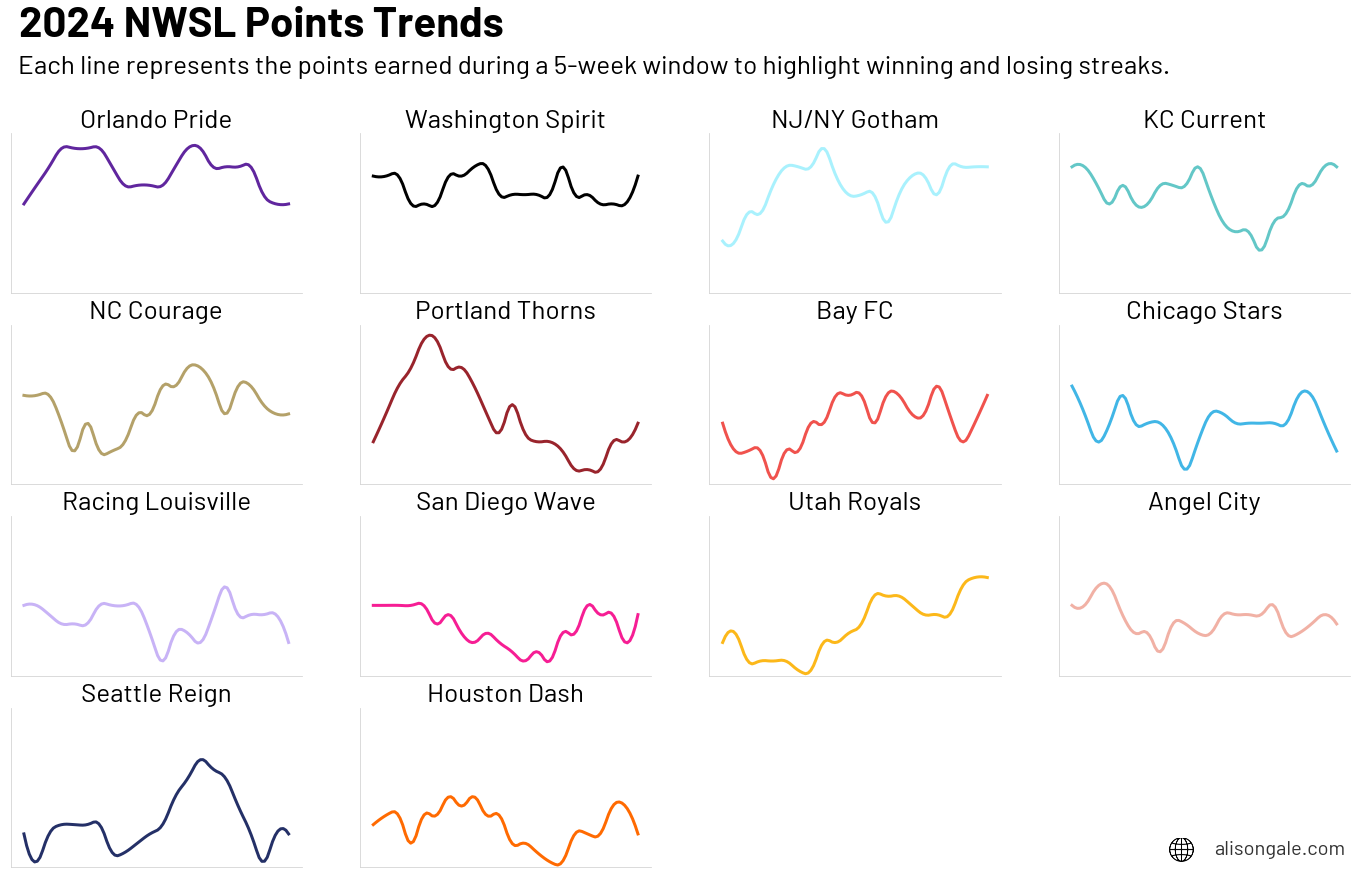

In [16]:
plt.clf()
plt.rcParams["figure.figsize"] = (24, 13.5)
plt.figure(dpi=1200, facecolor="white")
rows = 4
cols = 4
fig, axs = plt.subplots(rows, cols)
fig.patch.set_facecolor("white")

smooth = True

# Sort teams to order them by rank
standings = Data.get_nwsl_standings(df)["team"].tolist()

# Plot each team as a subplot
for i, team in enumerate(standings):
    ax = axs[int(i / cols), i % cols]

    if smooth:
        f = interp1d(list(df2.columns), df2.loc[team].to_numpy(), kind="quadratic")
        x2 = np.linspace(0, len(df2.columns) - 1, num=100)
        y2 = f(x2)
        ax.plot(
            x2,
            y2,
            linewidth=3,
            color=NWSL.COLORS[team],
        )
    else:
        ax.plot(
            df2.columns,
            df2.loc[team],
            linewidth=3,
            color=NWSL.COLORS[team],
        )
    ax.set_title(NWSL.NAMES[team], fontproperties=Fonts.BARLOW, size=26, y=1)
    ax.spines[["right", "top"]].set_visible(False)
    ax.spines[["left", "bottom"]].set_color(Colors.LIGHT_GRAY)
    ax.set_ylim([-0.6, 3 * window_size + 0.6 + 1])
    ax.set_xticks([])
    ax.set_yticks([])

for i in range(len(df2.index), rows * cols):
    ax = axs[int(i / cols), i % cols]
    ax.axis("off")

# Title
fig.suptitle(
    season + " NWSL Points Trends",
    fontproperties=Fonts.BARLOW_BOLD,
    size=42,
    ha="left",
    x=0.13,
    y=1.01,
)

# Subtitle
axs[0, 0].text(
    -0.5,
    23,
    "Each line represents the points earned during a 5-week window to highlight winning and losing streaks.",
    fontproperties=Fonts.BARLOW,
    size=26,
    ha="left",
)

add_signature(fig, x=0.79, y=0.13, fs=20, w=0.025)

# Save image
plt.savefig("images/moving_sum_" + season + ".png", bbox_inches="tight", pad_inches=0.5)